In [1]:
%load_ext autoreload
%autoreload 2
from mtsccleav import *
from aeon.utils.conversion import convert_collection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score
# from aeon.datasets import load_basic_motions
from aeon.transformations.collection.convolution_based import Rocket

In [3]:
ts_panel = load_as_pd_multiindex("../data/01_single_multi_eq.csv")
# ts_panel = load_as_pd_multiindex("../data/01_cum_st.csv")
X = construct_X(ts_panel, include_five_p_cleav=False, include_prob=True, include_ss=True)
X.fillna(-100, inplace=True)
X = pad_multiindex_ts(X,-100)
X_convert=convert_collection(X, "np-list")
y = np.concatenate((np.full((1, 827), 'cleav'), np.full((1, 827), 'non_cleav')), axis=None)
labelencoder = LabelEncoder()
y_transform = labelencoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_convert, y_transform, test_size=0.2, random_state=42)

In [4]:
# Fit ROCKET transformer
rocket = Rocket(n_kernels=10_000, random_state=42)
rocket.fit(X_train)
X_train_trans = rocket.transform(X_train)
X_test_trans = rocket.transform(X_test)

# Train a classifier
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_trans, y_train)
print("Test accuracy:", accuracy_score(y_test, clf.predict(X_test_trans)))


Test accuracy: 0.851963746223565


In [5]:
def sliding_window_importance(sample, rocket, clf, fill_value=0.0, window_size=4):
    # Step 1: Original score from classifier using the original features
    orig_feat = rocket.transform(sample[None, ...]) # Original features
    orig_scores = clf.decision_function(orig_feat)  # shape: (1,) or (1, C)
    pred_class = clf.predict(orig_feat)[0]

    # Step 2: Determine the relevant class score
    if orig_scores.ndim == 1:  # binary case → shape: (1,)
        orig_score = orig_scores[0]  # scalar
        class_index = int(pred_class == clf.classes_[1])  # class 1 = positive class
    else:  # multiclass → shape: (1, n_classes)
        orig_score = orig_scores[0]  # vector of class scores
        class_index = list(clf.classes_).index(pred_class)

    if isinstance(orig_score, np.ndarray):
        orig_score = orig_score[class_index]  # class-specific score

    # Step 3: Perturb/ Mask each time window and record drop in score
    # importance: each window (from sliding the window) by how much it affects classification confidence when masked.
    importance = []
    for start in range(sample.shape[1] - window_size + 1):
        perturbed = sample.copy()
        perturbed[:, start:start + window_size] = fill_value  # mask window, the first : across all channels

        pert_feat = rocket.transform(perturbed[None, ...])
        pert_scores = clf.decision_function(pert_feat)

        if pert_scores.ndim == 1:  # binary
            pert_score = pert_scores[0]
            pert_class_index = int(pred_class == clf.classes_[1])
        else:
            pert_score = pert_scores[0]
            pert_class_index = class_index

        if isinstance(pert_score, np.ndarray):
            pert_score = pert_score[pert_class_index]

        # Importance = drop in decision confidence
        drop = orig_score - pert_score
        importance.append(drop)

    return np.array(importance)


In [6]:
sample = X_test[5]  # shape (channels, time), Input: the first example in the test set.
importance = sliding_window_importance(sample, rocket, clf, window_size=4)

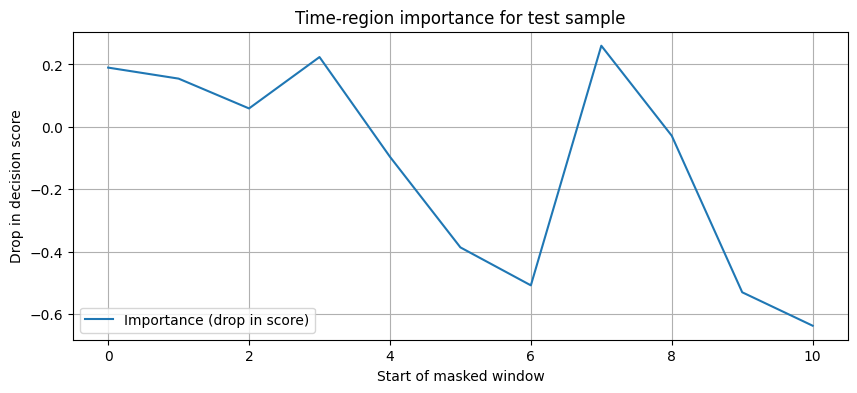

In [7]:
# Plot importance for one particular example
plt.figure(figsize=(10, 4))
plt.plot(importance, label="Importance (drop in score)")
plt.title(f"Time-region importance for test sample")
plt.xlabel("Start of masked window")
plt.ylabel("Drop in decision score")
plt.grid(True)
plt.legend()
plt.show()


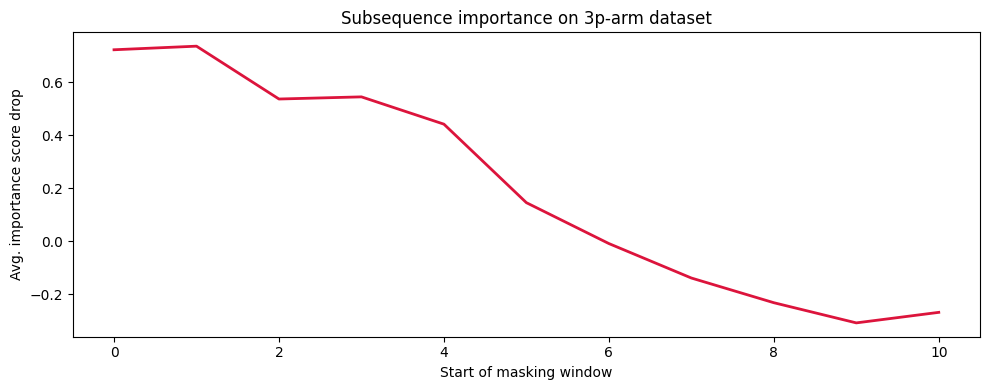

In [8]:
# Loop over all test samples
window_size = 4
# n_windows = X_test.shape[2] - window_size + 1
all_importances = []

for i in range(len(X_test)):
    imp = sliding_window_importance(X_test[i], rocket, clf, window_size=window_size)
    all_importances.append(imp)

# Step 5: Average across samples
avg_importance = np.mean(all_importances, axis=0)

# Step 6: Plot average importance curve
plt.figure(figsize=(10, 4))
plt.plot(avg_importance, color="crimson", lw=2)
plt.title(f"Subsequence importance on 3p-arm dataset")
plt.xlabel("Start of masking window")
plt.ylabel("Avg. importance score drop")
plt.grid(False)
plt.tight_layout()
plt.savefig("../figures/perturbation_3p.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [9]:
import datetime
print(f"This Notebook last end-to-end runs on: {datetime.datetime.now()}\n")
###
###
###

This Notebook last end-to-end runs on: 2025-07-08 23:13:50.532180

